# Lab: Clustering Unlabelled Data

This notebook is designed for **hands-on execution** with minimal code complexity while keeping the **same learning goals and results**.

## Learning Objectives
-  Understand **unsupervised learning** and why labels are not needed
-  Explore a real-world customer dataset and identify data quality issues
-  Apply **data preprocessing** (transformation + scaling) correctly
-  Perform clustering using **K-Means**, **Hierarchical**, and **DBSCAN**
-  Select a suitable number of clusters using **inertia** and **silhouette**
-  Identify **outliers and noise** using DBSCAN
-  Visually interpret clustering results

## 📦 Dataset
We use the **Wholesale Customers Dataset** (UCI ML Repository):

-  440 customers
-  8 numerical features (annual spending categories)
-  Commonly used for customer segmentation

**File needed:** `Wholesale_customers_data.csv` in the same folder as this notebook.

##  Cell 0 — Setup 

###  What this cell does
- Imports required libraries
- Suppresses warnings (clean output)
- Fixes randomness for reproducibility

In [1]:
import os, warnings
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Windows safety
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



random_state = 42


##  Cell 1 — Load and Inspect the Data

### What this cell does
- Loads the dataset from CSV
- Shows dataset shape and first rows
- Helps you understand features and ranges

In [2]:
X0 = pd.read_csv("Wholesale_customers_data.csv")
print("Shape:", X0.shape)
X0.head()


Shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


##  Cell 2 — Quick EDA (Boxplots)

### What this cell does
- Boxplots reveal **outliers** and **scale differences**
- This motivates preprocessing before clustering

**Think about:** Which features are skewed? Which have extreme outliers? Why is this a problem for distance-based models?

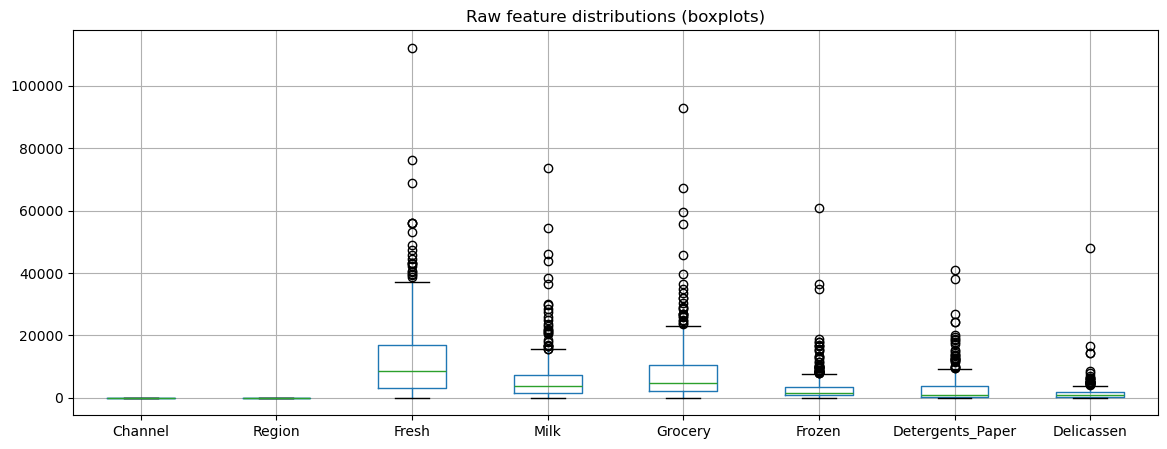

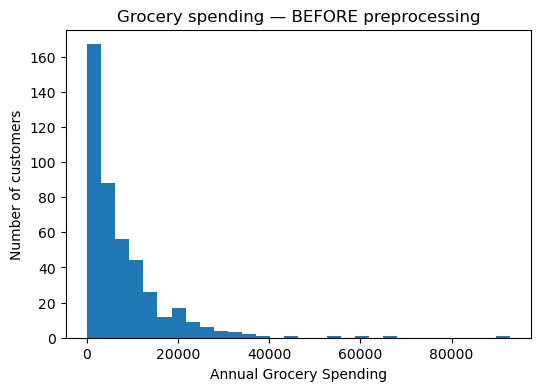

In [4]:
plt.figure(figsize=(6,4))
plt.hist(X0["Grocery"], bins=30)
plt.title("Grocery spending — BEFORE preprocessing")
plt.xlabel("Annual Grocery Spending")
plt.ylabel("Number of customers")
plt.show()


## Cell 3 — Preprocessing (Most Important)

### Why preprocessing is needed
Clustering relies on **distances**. Raw data often has:
- Different scales (one feature dominates distances)
- Strong skewness

We apply:
- `PowerTransformer` → reduce skewness
- `MinMaxScaler` → scale features to **[0, 1]**

In [5]:
spend_cols = X0.columns[2:]  # spending features only (Fresh ... Delicassen)

# 1) Reduce skewness on spending columns


# 2) Combine Channel, Region with transformed spending


# 3) Scale everything to [0, 1]

print("Data transformed and scaled. Ready for clustering!")


Data transformed and scaled. Ready for clustering!


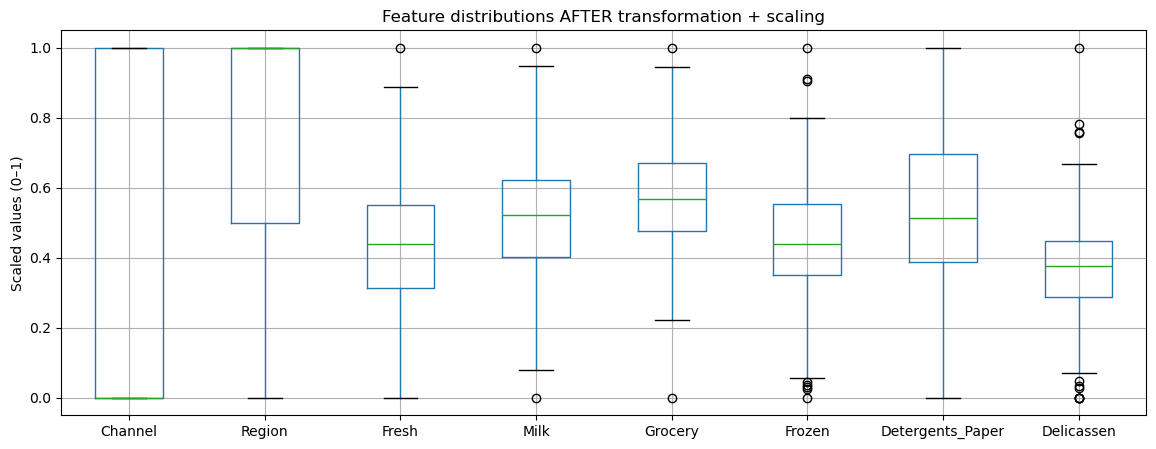

In [6]:
# Convert preprocessed array back to DataFrame for plotting


X_preprocessed.boxplot(figsize=(14,5))
plt.title("Feature distributions AFTER transformation + scaling")
plt.ylabel("Scaled values (0–1)")
plt.show()


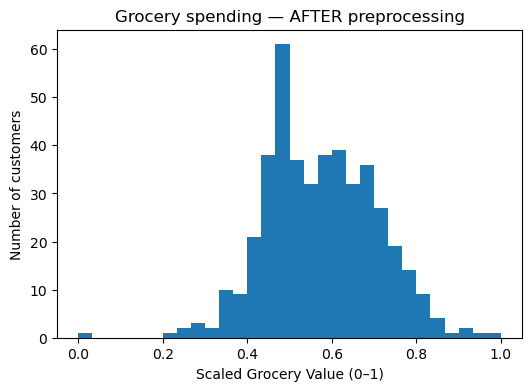

In [7]:
plt.figure(figsize=(6,4))
plt.hist(X_preprocessed["Grocery"], bins=30)
plt.title("Grocery spending — AFTER preprocessing")
plt.xlabel("Scaled Grocery Value (0–1)")
plt.ylabel("Number of customers")
plt.show()


# PART A — K-Means Clustering

K-Means requires choosing **k** (number of clusters). We use:
- 📉 **Inertia** (Elbow method)
- 📈 **Silhouette score** (higher is better)

##  Cell 4 — Choose k using Inertia + Silhouette

###  What this cell does
- Trains K-Means for **k = 2 … 10**
- Stores inertia and silhouette
- Plots both to guide selection

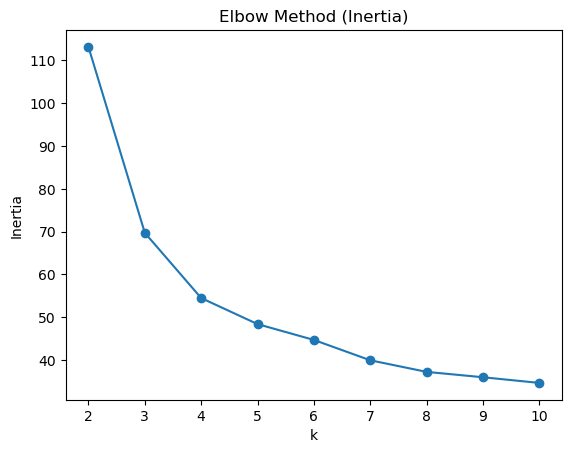

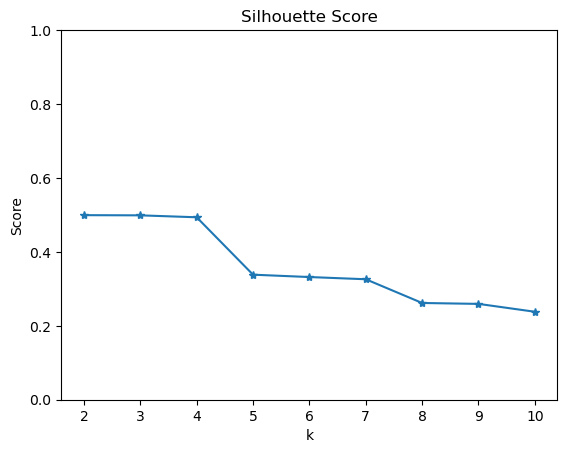

In [8]:



plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.plot(list(ks), sils, marker="*")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


## Cell 5 — Train Final K-Means Model

###  What this cell does
- Sets a final **k** (default 4)
- Fits K-Means and prints silhouette
- Visualises clusters using a simple 2D scatter plot

📌 We plot `Grocery` vs `Detergents_Paper` because it often shows clear separation.

KMeans silhouette: 0.494


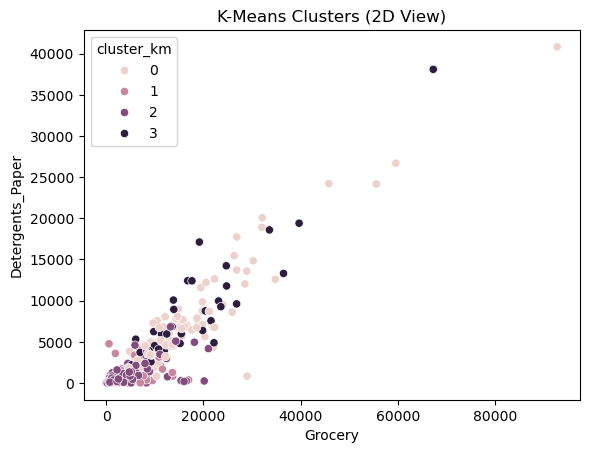

In [9]:
k = 4  # adjust if your plots suggest a different k

km = KMeans(n_clusters=k, random_state=random_state)
y_km = km.fit_predict(X)

print("KMeans silhouette:", round(silhouette_score(X, y_km), 3))

X0_easy = X0.copy()
X0_easy["cluster_km"] = y_km

sns.scatterplot(data=X0_easy, x="Grocery", y="Detergents_Paper", hue="cluster_km")
plt.title("K-Means Clusters (2D View)")
plt.show()


# PART B — Hierarchical (Agglomerative) Clustering

Agglomerative clustering builds clusters bottom-up. We keep it simple: **ward linkage** and the **same k** as K-Means.

## Cell 6 — Fit Agglomerative Model

### What this cell does
- Fits Agglomerative clustering (ward)
- Computes silhouette
- Visualises clusters in the same 2D view

Agglomerative silhouette: 0.493


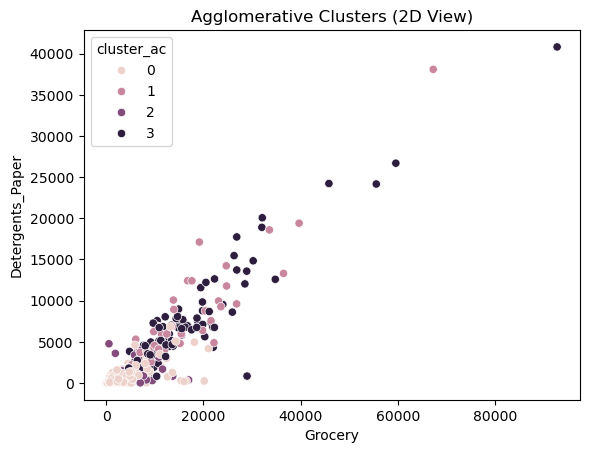

In [10]:


print("Agglomerative silhouette:", round(silhouette_score(X, y_ac), 3))

X0_easy["cluster_ac"] = y_ac

sns.scatterplot(data=X0_easy, x="Grocery", y="Detergents_Paper", hue="cluster_ac")
plt.title("Agglomerative Clusters (2D View)")
plt.show()


## Cell 7 — Compare K-Means vs Agglomerative

### What this cell does
- Measures agreement between the two clusterings
- High agreement suggests stable cluster structure

In [11]:
pcm = pair_confusion_matrix(y_km, y_ac)
agreement = pcm.diagonal().sum() / pcm.sum()
print(f"Cluster agreement ≈ {agreement*100:.2f}%")


Cluster agreement ≈ 99.69%


# PART C — DBSCAN (Density-Based Clustering)

DBSCAN does **not** require k. It finds dense regions and marks sparse points as **noise**.

- Noise points have label **-1** 🧹

##  Cell 8 — Fit DBSCAN + Detect Noise

###  What this cell does
- Runs DBSCAN with default parameters
- Prints unique la
- bels (including -1)
- Visualises clusters in 2D

📌 If results look messy, DBSCAN may need tuning (`eps`, `min_samples`).

DBSCAN labels: [-1  0  1  2  3  4  5] (noise = -1)


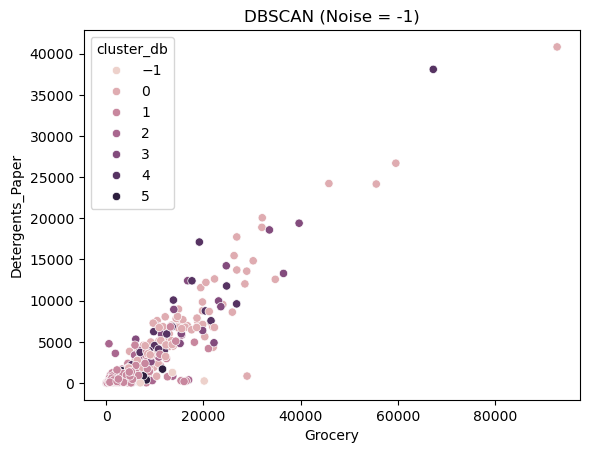

In [12]:


X0_easy["cluster_db"] = y_db
print("DBSCAN labels:", np.unique(y_db), "(noise = -1)")

sns.scatterplot(data=X0_easy, x="Grocery", y="Detergents_Paper", hue="cluster_db")
plt.title("DBSCAN (Noise = -1)")
plt.show()


## Model Comparison Summary

| Method | Strength ✅ | Limitation ⚠️ |
|---|---|---|
| K-Means | Fast, simple, interpretable | Must choose k |
| Agglomerative | Captures hierarchical structure | Slower, still needs k |
| DBSCAN | Finds noise/outliers; no k | Sensitive to parameters |

## Learning Outcomes
After completing this lab, students will be able to:

- Segment customers based on annual spending behaviour 🛒
- Explain why preprocessing is critical for distance-based algorithms ⚠️
- Justify clustering decisions using plots and metrics 📉📈
- Compare clustering strategies and discuss business implications 🧭
- Critically interpret clustering outputs (not just run code)

## ❓ Control Questions (Submit Answers)

1) Repeat K-Means **without preprocessing**. What changes and why?
2) Fit K-Means for **k-1** and **k+1** relative to your chosen k. What changes?
3) When would DBSCAN be a better business tool than K-Means?
4) What does silhouette fail to capture in real-world segmentation?

## 🌟 Key Takeaways

- 🧼 Preprocessing often matters more than the algorithm
- 📏 Scaling is mandatory for distance-based clustering
- 📈 Silhouette helps but must be paired with visual inspection
- 🧹 DBSCAN is useful for outliers and irregular cluster shapes

🎓 **End of Lab — Well Done!**